In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
def npmap2d(fun, xs, ys, doPrint=False):
  Z = np.empty(len(xs) * len(ys))
  i = 0
  for y in ys:
    for x in xs:
      Z[i] = fun(x, y)
      if doPrint: print([i, x, y, Z[i]])
      i += 1
  X, Y = np.meshgrid(xs, ys)
  Z.shape = X.shape
  return X, Y, Z

## Distributions

In [3]:
mu1 = np.array([0, 0])
sigma1 = np.sqrt(1)
mu2 = np.array([2, 0])
sigma2 = np.sqrt(4)
D1 = sigma1**2
D2 = sigma2**2

def pdf(x, mu, sigma):
    offset = x - mu
    r = offset.dot(offset)
    y = 1/(2*np.pi*sigma*sigma)*np.exp(-offset.dot(offset)/(2*sigma*sigma))
    return y

(0.0, 0.1)

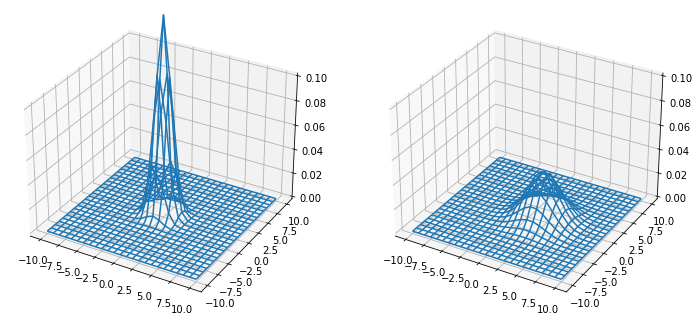

In [4]:
n_points = 25
x1s = np.linspace(-10, 10, n_points)
x2s = np.linspace(-10, 10, n_points)
X1, X2, Y = npmap2d(lambda x1, x2: pdf(np.array([x1, x2]), mu1, sigma1), x1s, x2s)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X1, X2, Y)
ax.set_zlim(0, 0.1)

x1s = np.linspace(-10, 10, n_points)
x2s = np.linspace(-10, 10, n_points)
X1, X2, Y = npmap2d(lambda x1, x2: pdf(np.array([x1, x2]), mu2, sigma2), x1s, x2s)

# fig = plt.figure()
ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(X1, X2, Y)
ax.set_zlim(0, 0.1)

# ax.scatter(X1, X2, Y)
# for i in range(X1.size):
#     x1, x2, y = X1.ravel()[i], X2.ravel()[i], Y.ravel()[i]
#     x1s = [x1, x1]
#     ax.plot([x1, x1], [x2, x2], [0, y])

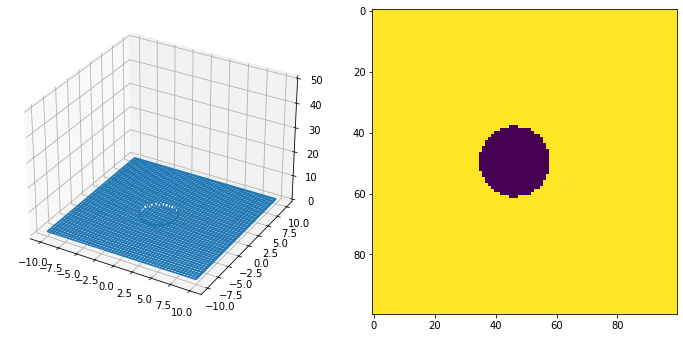

In [5]:
n_points = 100
x1s = np.linspace(-10, 10, n_points)
x2s = np.linspace(-10, 10, n_points)
X1, X2, Y = npmap2d(lambda x1, x2: pdf(np.array([x1, x2]), mu1, sigma1) < pdf(np.array([x1, x2]), mu2, sigma2) , x1s, x2s)


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X1, X2, Y)
ax.set_zlim(0, 50)
Y

ax = fig.add_subplot(122)
ax.imshow(Y)

# Generate points

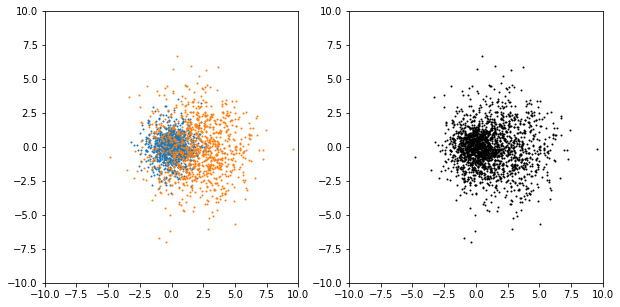

In [6]:
n_points = 1000

def random_custDist(n, pdf):
    samples = np.empty((n, 2))
    i = 0
    while i < n:
        x = np.random.uniform(-10, 10, 2)
        p = pdf(x)
        if np.random.uniform(low=0,high=1) <= p:
            samples[i] = x
            i += 1
    return np.array(samples)


x1s = random_custDist(n_points, lambda x: pdf(x, mu1, sigma1))
x2s = random_custDist(n_points, lambda x: pdf(x, mu2, sigma2))
# xs, np.hsplit(xs, 2)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.scatter(*np.hsplit(x1s, 2), s=1)
ax1.scatter(*np.hsplit(x2s, 2), s=1)

xs = np.concatenate([x1s, x2s])
ys = np.concatenate([np.ones(len(x1s)), -np.ones(len(x2s))]).reshape(-1, 1)
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.scatter(*np.hsplit(xs, 2), s=1, c='#000')
# ax2.scatter(*np.hsplit(x2s, 2), s=1, c='#000')

## Bayes

2.34

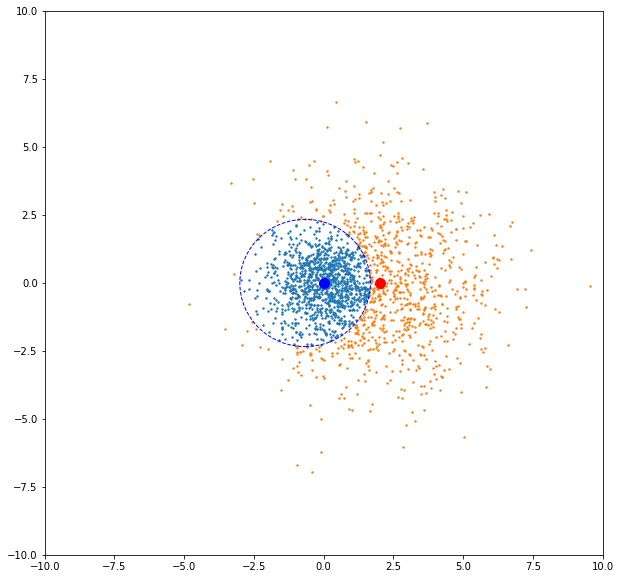

In [7]:
def lambda_x(x, mu1, sigma1, mu2, sigma2):
    D1 = sigma1**2
    D2 = sigma2**2
    offset1 = x - mu1
    offset2 = x - mu2
    lambd = D2 / D1 * np.exp(-1/2/D1 * (offset1.dot(offset1)) + 1/2/D2 * offset2.dot(offset2))
    return lambd

x_c = (D2*mu1 - D1*mu2) / (D2-D1)
mu_offset = mu1 - mu2
r_sq = D2*D1/(D2-D1)*(mu_offset.dot(mu_offset) / (D2-D1) + 4*np.log(D2/D1))
r = np.sqrt(r_sq)
r = 2.34

C1 = []
C2 = []
for x in x1s:
    l = lambda_x(x, mu1, sigma1, mu2, sigma2)
    if (l > 1): C1.append(x)
    else: C2.append(x)
for x in x2s:
    l = lambda_x(x, mu1, sigma1, mu2, sigma2)
    if (l > 1): C1.append(x)
    else: C2.append(x)


fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.scatter(*np.hsplit(np.array(C1), 2), s=2)
ax1.scatter(*np.hsplit(np.array(C2), 2), s=2)
circle = plt.Circle(x_c, r, color='blue', fill=False, linestyle='--')
ax1.add_artist(circle)
ax1.scatter(*mu1, s=100, color='blue')
ax1.scatter(*mu2, s=100, color='red')
r

## RBF

In [8]:
class Rbf:
    def _gauss(self, x, mu=0, sigma=1):
        return 1/sigma/np.sqrt(2*np.pi) * np.exp(-((x - mu) ** 2) / 2 / (sigma ** 2))

    def fit(self, X, D, sigma):
        N = X.shape[0]
        m0, m1, M = X.shape[1], N, D.shape[1]
        
        centers = X
        distances = np.zeros((N, m1))
        for i, c in enumerate(centers):
            distances[:, i] = np.sqrt( ((X - c) ** 2).sum(axis=1) )
        kernel_outputs = self._gauss(distances, 0, sigma)
        W = np.linalg.inv(kernel_outputs) @ D
        
        self.m1 = m1
        self.centers = centers
        self.W = W
        self.sigma = sigma

        Y = kernel_outputs @ W
        err = ((Y - D) ** 2).sum() / N
        return err

    def predict(self, X):
        N, m1, centers, W, sigma = len(X), self.m1, self.centers, self.W, self.sigma

        distances = np.zeros((N, m1))
        for i, c in enumerate(centers):
            distances[:, i] = np.sqrt( ((X - c) ** 2).sum(axis=1) )
        kernel_outputs = self._gauss(distances, 0, sigma)
        Y = kernel_outputs @ W
        return Y

2.501403974745964e-28


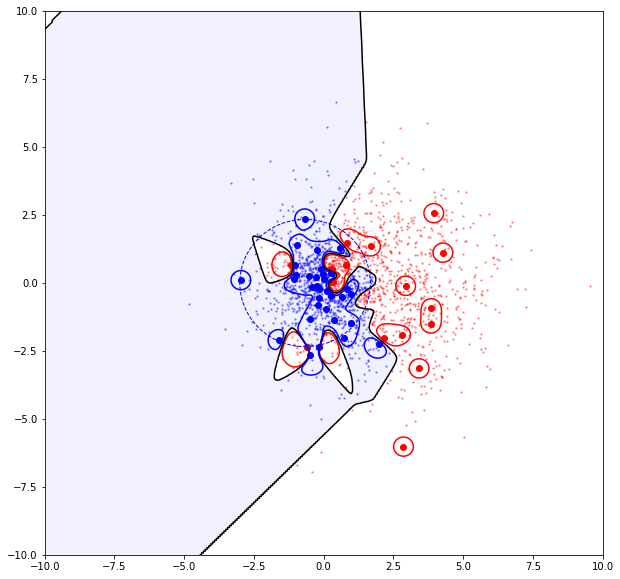

In [9]:
xs
ds = ys

N = 50
idx_train = np.random.choice(np.arange(len(xs)), replace=False, size=N)
xs_train, ds_train = xs[idx_train], ds[idx_train]

kernel_size = 0.3
rbf = Rbf()
err = rbf.fit(xs_train, ds_train, kernel_size)
print(err)

ys_pred = rbf.predict(xs)

idx_c1 = ys_pred[:, 0] > 0
c1_pred = xs[idx_c1]
c2_pred = xs[~idx_c1]


fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.scatter(*np.hsplit(np.array(c1_pred), 2), s=2, c='#00f5')
ax1.scatter(*np.hsplit(np.array(c2_pred), 2), s=2, c='#f005')
ax1.scatter(*np.hsplit(xs_train[ds_train[:,0] > 0], 2), marker='o', c='#00ff')
ax1.scatter(*np.hsplit(xs_train[ds_train[:,0] < 0], 2), marker='o', c='#f00f')
circle = plt.Circle(x_c, r, color='blue', fill=False, linestyle='--')
ax1.add_artist(circle)


n_points = 300
x1s = np.linspace(-10, 10, n_points)
x2s = np.linspace(-10, 10, n_points)
X1, X2 = np.meshgrid(x1s, x2s)
xs_plot = np.vstack([X1.ravel(), X2.ravel()]).T
ys_plot = rbf.predict(xs_plot)
ys_plot = (ys_plot).reshape(X1.shape)

ax1.contourf(X1, X2, ys_plot, levels=0, colors=['#ff000000', '#0000ff0f'])
ax1.contour(X1, X2, ys_plot, levels=[-0.5, 0, 0.5], colors=['red', 'k', 'blue'])

## SVM
broken

(2000, 25) (25, 1) (25, 1) 2.0116933898587686 (25, 1)
(90000, 25) (25, 1) (25, 1) 2.0116933898587686 (25, 1)


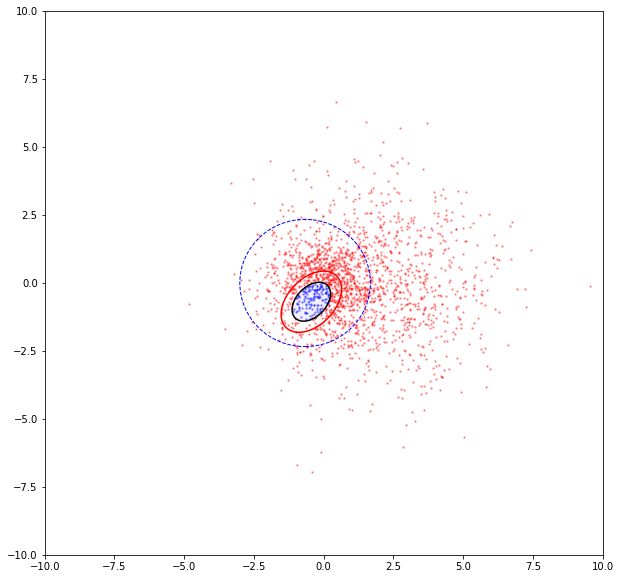

In [10]:
import cvxpy

class Svm:
    def fit(self, X, D, C=1):
        K = (X @ X.T + 1) ** 2
        
        a = cvxpy.Variable(shape=D.shape)
        P = (D @ D.T) * K
        Q = cvxpy.sum(a) - 1/2 * cvxpy.quad_form(a, P)
        objective = cvxpy.Maximize(Q)
        constraints = [
            cvxpy.sum(cvxpy.multiply(a, D)) == 0,
            0 <= a,
            a <= C,
        ]
        problem = cvxpy.Problem(objective, constraints)
        result = problem.solve()
        a = a.value
        Q = Q.value
        support_idxs = (a > 1e-4).flatten()
        self.support_X = X[support_idxs]
        self.support_D = D[support_idxs]
        self.support_a = a[support_idxs]
        self.w_norm = (2*Q.sum())**0.5
#         print(a, Q, support_idxs.sum())
        
    def predict(self, X):
        sX, sD, sa = self.support_X, self.support_D, self.support_a
#         print(sX, sD, sa)
        K = (X @ sX.T + 1) ** 2
#         print(K)
        print(K.shape, sa.shape, sD.shape, self.w_norm, (sa*sD* self.w_norm).shape)
        predictions = K @ (sa*sD* self.w_norm)
        return predictions
        
xs
ds = ys

N = 50
idx_train = np.random.choice(np.arange(len(xs)), replace=False, size=N)
xs_train, ds_train = xs[idx_train], ds[idx_train]

C = 0.1
svm = Svm()
svm.fit(xs_train, ds_train, C)

ys_pred = svm.predict(xs)
idx_c1 = ys_pred[:, 0] > 0
c1_pred = xs[idx_c1]
c2_pred = xs[~idx_c1]


# plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.scatter(*np.hsplit(np.array(c1_pred), 2), s=2, c='#00f5')
ax1.scatter(*np.hsplit(np.array(c2_pred), 2), s=2, c='#f005')
circle = plt.Circle(x_c, r, color='blue', fill=False, linestyle='--')
ax1.add_artist(circle)

n_points = 300
x1s = np.linspace(-10, 10, n_points)
x2s = np.linspace(-10, 10, n_points)
X1, X2 = np.meshgrid(x1s, x2s)
xs_plot = np.vstack([X1.ravel(), X2.ravel()]).T
ys_plot = svm.predict(xs_plot)
ys_plot = (ys_plot).reshape(X1.shape)

ax1.contourf(X1, X2, ys_plot, levels=0, colors=['#ff000000', '#0000ff0f'])
ax1.contour(X1, X2, ys_plot, levels=[-0.5, 0, 0.5], colors=['red', 'k', 'blue'])